# Timelapse Image Segmentation to Measure Sunlight Hours
__(a.k.a. the reality of what I actually use my GoPro for)__


I live in sunny California, but because my yard has so many trees and structures, I was curious how many hours of direct sunlight each location actually gets. I recorded a timelapse of a summer day, applied methods of image segmentaion in Python to detect direct sunlight, and then aggregated over the day to calculate the spatial distribution of sunlight hours.

Original Image             |  Binary Segmentation      |  Cumulative Sunlight
:-------------------------:|:-------------------------:|:-------------------------:
![SegmentLocal](raw_timelapse.gif "segment")  |  ![SegmentLocal](Binary_classifier_timelapse.gif "segment") |  ![SegmentLocal](Cumulative_classifier_timelapse.gif "segment")


## Goal

Identify the locations in the yard which recieve high and low ammounts of direct sunlight, which can inform what plants would do well in certain locations.

![SegmentLocal](final_plot.png "segment") 

## Data

Over 700 .jpg images, taken on 1 minute intervals over a summer day (only during sunlight hours).

## Approach

1) Load and process images
- resize
- apply Gaussian blur
- convert to grayscale
    
2) Apply spatial standardization by adjusting pixels by baseline values of image with no direct sunlight

3) Threshold segmentation using OTSU's Binaritization

4) Aggregate images across timelapse to calculate total direct sunlight hours for each pixel


## Code and Walkthrough

Below is my code and explanations for how I answered my question.

### Data Management

First I imported the relevant packages I'd use:

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import rgb2hex
from PIL import Image
from PIL.ExifTags import TAGS
import matplotlib.cm as cm
import matplotlib.animation as animation
from sklearn.cluster import KMeans


Next I defined several functions...

The first function simply loads the .jpg image, and converts it to RGB (since the default format is BGR). 



In [2]:
def load_jpg(filename):
    
    #Load Image
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

The next function processes the image with a couple steps:

1) Resize the image
- For my purpose, I didn't need a high resolution and so I reduced the size for faster computing times.

2) Apply a Gaussian blur
- This helps smooth out some of the noise, like from leaves on the lawn.

3) Convert to grayscale
- For my purposes, I do not need color information, and the grayscale value provides the most useful information for determining shade/sun.  This also puts it in the format needed to apply a threshold.

In [3]:
def process_img(img):

    #resize (cut width and height by 90% since don't need high resolution for image segmentation)
    height, width, ncategories = img.shape
    newwidth = int(width/10)
    newheight = int(height/10)
    img_small = cv2.resize(img, (newwidth,newheight), interpolation = cv2.INTER_AREA) 
    
    #Add Gaussian Blur to smooth out some of the noise (e.g. leaves on the ground)
    blur = cv2.GaussianBlur(img_small, (3,3), 0)

    #convert to grayscale 
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    
    return gray

This last function is used to segment the image into shade vs sun.  I use OTSU's Binaritization because I am trying to classify my image into two classes (shade/sun), but there are many different objects with different colors, and so a global threshold would be inneffective.

In [4]:
def segment_img(img):
    #Define threshold with OTSU's Binaritization
    thresh_img = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    return thresh_img


### First Challenges

To evaluate how well my segmentation worked, I considered several representative times (morning/noon/afternoon/evening). In the plots below, I show original image (left) / processed image (middle) / Binary Threshold Segmentation (right), for 8am, 12pm, 4pm and 6pm. 

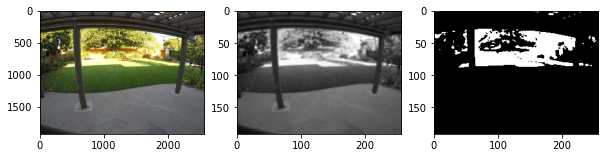

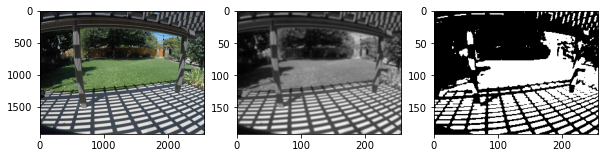

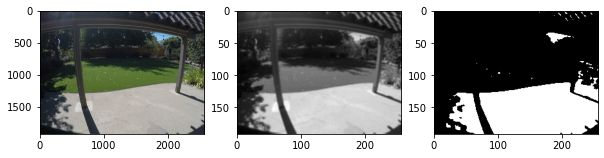

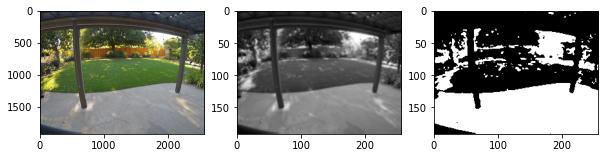

In [5]:
#Plot Example Images

# 8am / Noon / 4pm / 6pm 
representative_times = ['./raw_images/'+ fn +'.jpg' for fn in ['G0059661','G0059901','G0060141','G0060261'] ]

#Plot raw image / processed image / segmented image
for fn in representative_times:
    raw_img = load_jpg(fn)
    proc_img = process_img(raw_img)
    binary_img = segment_img(proc_img)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1)
    plt.imshow(raw_img)
    plt.subplot(1,3,2)
    plt.imshow(proc_img, cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(binary_img, cmap="gray")
    plt.show()


What I found is that the segmentation worked very well at certain times (8am and noon), but at other times (4pm and 6pm), the threshold picked up on the contrast between the concrete patio and the lawn, rather than the shade and the sun.  

To show this further, we can cluster our image (using K-means), and consider the distribution of grayscale values on the patio compared to the vegetation. First, we will cluster on an image without direct sunlight to remove any noise from sun/shade.

Text(0.5, 1.0, 'Clustered Image')

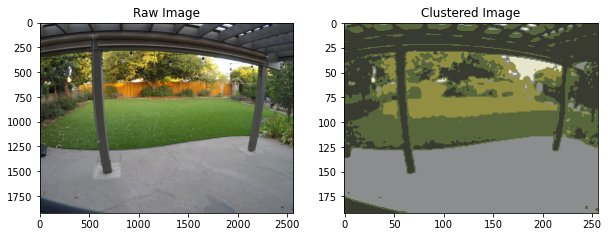

In [6]:
#load image with no direct sun
raw_nosun = load_jpg('./dropped_raw_images/G0059601.jpg')

#resize and blur (but keep as color image)
height, width, ncategories = raw_nosun.shape
newwidth = int(width/10)
newheight = int(height/10)
proc_nosun = cv2.resize(raw_nosun, (newwidth,newheight), interpolation = cv2.INTER_AREA) 

#Add Gaussian Blur to smooth out some of the noise (e.g. leaves on the ground)
proc_nosun = cv2.GaussianBlur(proc_nosun, (3,3), 0)

#scale so between 0 and 1, and then reshape for fitting K-means
proc_nosun = proc_nosun/255
proc_nosun_reshape = proc_nosun.reshape(proc_nosun.shape[0]*proc_nosun.shape[1], proc_nosun.shape[2])


#K-means clustering (k=5 had best classification of patio as single object but distinct from sky)
kmeans = KMeans(n_clusters=5, random_state=0).fit(proc_nosun_reshape)
clustervalues = kmeans.cluster_centers_[kmeans.labels_]
cluster_nosun = clustervalues.reshape(proc_nosun.shape[0], proc_nosun.shape[1], proc_nosun.shape[2])

#plot original image and clustered image
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.imshow(raw_nosun)
plt.title("Raw Image")
plt.subplot(1,2,2)
plt.imshow(cluster_nosun)
plt.title("Clustered Image")

Now, we will plot histograms of the grayscale value distribution grouped by clusters.  We show one example where the threshold did well (noon), and one where the threshold did poorly (4pm).

<AxesSubplot:title={'center':'4pm (Bad Threshold Fit)'}, ylabel='Frequency'>

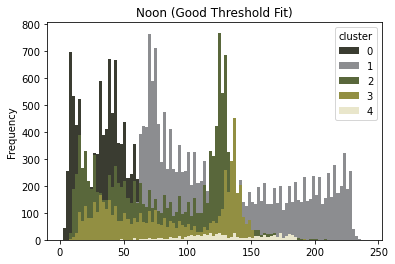

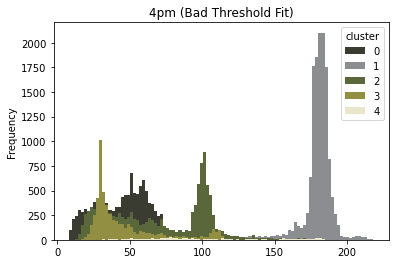

In [7]:
#load noon (Threshold performed well) image and convert to dataframe
noon =  load_jpg('./raw_images/G0059901.jpg') 
noon = process_img(noon)
noondf = pd.DataFrame({'grayscale':noon.flatten(),'cluster':kmeans.labels_,'cluster_hex':[rgb2hex(ar) for ar in clustervalues]  })

#load 4pm (Threshold did not perform well) image and convert to dataframe
fourpm =  load_jpg('./raw_images/G0060141.jpg') 
fourpm = process_img(fourpm)
fourpmdf = pd.DataFrame({'grayscale':fourpm.flatten(),'cluster':kmeans.labels_,'cluster_hex':[rgb2hex(ar) for ar in clustervalues] })



# Plot histogram of greyscale values colored by cluster
noondf.pivot(columns="cluster", values="grayscale").plot.hist(bins=100,title="Noon (Good Threshold Fit)",color=[rgb2hex(ar) for ar in kmeans.cluster_centers_])
fourpmdf.pivot(columns="cluster", values="grayscale").plot.hist(bins=100,title="4pm (Bad Threshold Fit)",color=[rgb2hex(ar) for ar in kmeans.cluster_centers_])


As we can see above, in the noon picture, each cluster has a bimodal distribution of grayscale values, since there are significant amounts of shade and sun on all surfaces. There is significant overlap in the clusters, allowing for the variation due to sunlight to stand out. At 4pm on the other hand, the patio is almost entirely in the sun, causing the distribution of the patio's grayscale values to be far away from that of the other vegetation clusters. The grayscale distributions of the vegetative clusters are still biomodal, as there is shade and sun.  However, a threshold will pick up on the difference *across* the spatial clusters, rather than the difference *within* clusters related to sunlight.

### Image Standardization

This spatial variation coming from differences between concrete and lawn is (somewhat) time-independent.  That is, the concrete is a lighter shade than the lawn in all photos (before considering any sun/shade impacts). I therefore decided to take the approach of standardizing all images by subtracting each pixel's grayscale value in an image where no direct sun was present.

This is similar to detrending in time series modeling where a long term trend is subtracted to isolate short term variation.  Here, we want to remove the variation from object materials so that we can isolate the sun/shade variation. We will use the average of the early morning and late evening pictures directly before/after direct sunlight is present as a baseline.

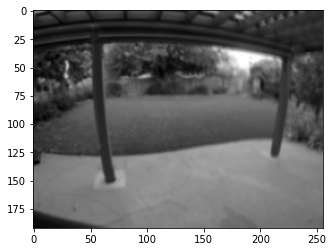

In [8]:
#load images of 7am/7:30pm (when no direct sun)
raw_base1 = load_jpg('./dropped_raw_images/G0059601.jpg') 
raw_base2 = load_jpg('./raw_images/G0060351.jpg') 

#calculate baseline image as average (need to do some rescaling to make sure it is still a valid image)
raw_base_avg = raw_base1/2 + raw_base2/2
raw_base_avg -= np.amin(raw_base_avg)
raw_base_avg = raw_base_avg * 255/np.amax(raw_base_avg)
raw_base_avg = raw_base_avg.astype('uint8')

#apply same processing (resize/gaussian blur/grayscale)
proc_base = process_img(raw_base_avg)

#plot
plt.imshow(proc_base, cmap="gray")
plt.show()


We will now adjust our images by subtracting these baseline (no-sun) values from each pixel, and reapply our threshold segmentation.  The plots below show original image / processed image / original threshold segmentation / adjusted image / new threshold segmentation. 

As you can see in the adjusted images (2nd plot from the right), there is less contrast between the patio and lawn compared to the original processed image (2nd plot from the left), leading to the new segmentation (right plot) to perform better.

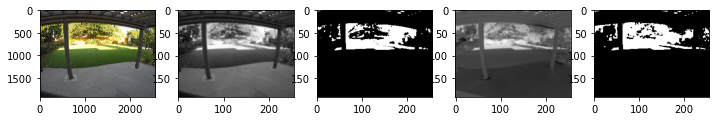

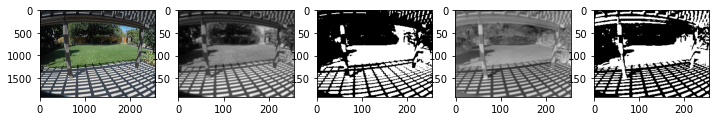

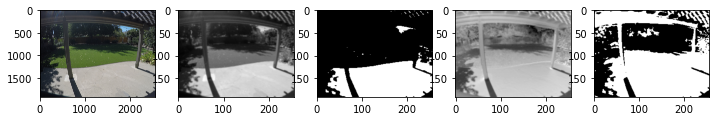

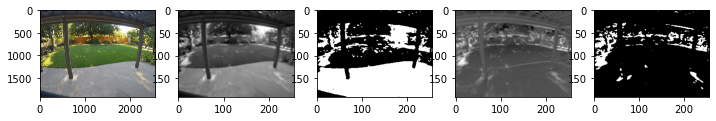

In [9]:

#Plot raw image / processed image / standardized image / segmented image
for fn in representative_times:
    raw_img = load_jpg(fn)
    proc_img = process_img(raw_img)
    #stnd_img = proc_img - proc_base
    diff_array = (proc_img.copy()/255  - proc_base.copy()/255) 
    diff_array -= np.amin(diff_array)
    diff_array = diff_array * 255/np.amax(diff_array)
    diff_array = diff_array.astype('uint8')

    binary_img = segment_img(proc_img)
    #stnd_binary_img = segment_img(stnd_img)
    stnd_binary_img = segment_img(diff_array)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,5,1)
    plt.imshow(raw_img)
    plt.subplot(1,5,2)
    plt.imshow(proc_img, cmap="gray")
    plt.subplot(1,5,3)
    plt.imshow(binary_img, cmap="gray")
    plt.subplot(1,5,4)
    plt.imshow(diff_array, cmap="gray")
    plt.subplot(1,5,5)
    plt.imshow(stnd_binary_img, cmap="gray")
    plt.show()



## Process Entire Day

We now apply the above procedure on images from the entire day, and aggregate the binary classification of sun/shade at each timepoint to come up with a cumulative measure of sunlight.

In [10]:
# All raw images filenames
raw_image_fn = glob.glob("./raw_images/*.JPG") 

#only take every 5th minute (1 minute interval is excessive for this)
raw_image_fn_5min = raw_image_fn[:len(raw_image_fn):5]

#Create empty lists to store image arrays
raw_img_array = []
binary_img_array = []
cum_img_array = []

#Save raw image / processed image / segmented image arrays
for fn in raw_image_fn_5min:
    #raw image
    raw_img = load_jpg(fn)
    #processed image
    proc_img = process_img(raw_img)
    #adjustment for baseline values
    diff_array = (proc_img.copy()/255  - proc_base.copy()/255) 
    diff_array -= np.amin(diff_array)
    diff_array = diff_array * 255/np.amax(diff_array)
    diff_array = diff_array.astype('uint8')
    #Threshold Binaritization (based on processed image adjusted for baseline values)
    binary_img = segment_img(diff_array)
    
    #Define cumulative hours of sunlight (5 minute intervals so divide by 12 to get hours)
    if fn == raw_image_fn[0]:
        cum_img = binary_img/12
    else:
        cum_img += binary_img/12
        
    #append array to list    
    raw_img_array.append(raw_img)
    binary_img_array.append(binary_img)
    cum_img_array.append(cum_img.copy())


The above code created lists of arrays for the raw image, binary segmentation and cumulative hours of sunlight for each timepoint.  This next code creates the GIFs displayed at the beginning of this page.

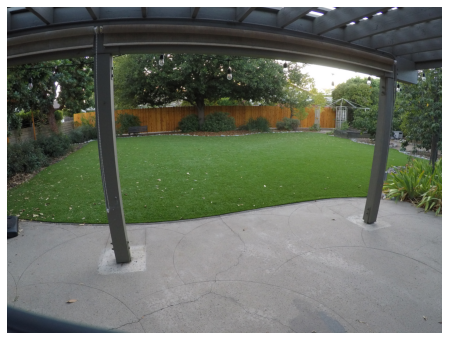

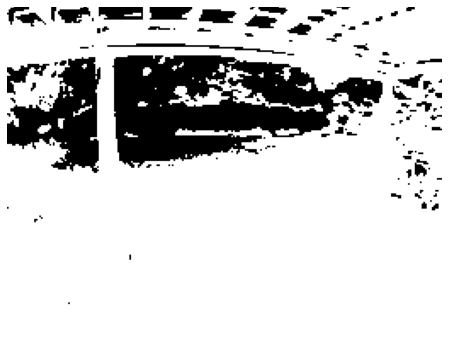

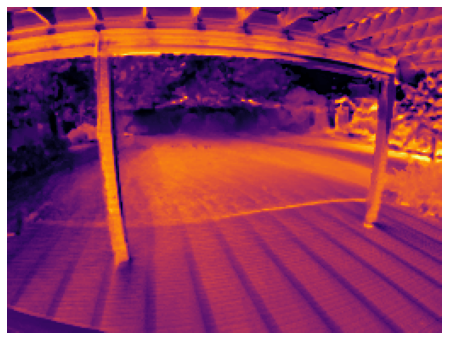

In [11]:
"""
-------------------------------------------------------------------------------
Function to create GIFs
-------------------------------------------------------------------------------
Inputs:
        > img_array = list of image arrays
        > filename = string to save file as
        > manual_cmap (optional) = cmap parameter
        > manual_clim (optional) = max color limit parameter
        > gif_length = seconds the gif will last (default=10sec)
    Outputs:
        > writes GIF to file
""" 
def create_gif(img_array,filename,manual_cmap=None, manual_max_clim=None,gif_length=10):

    frames_raw = [] 
    fig = plt.figure(figsize=(8, 6))
    plt.axis('off')
    
    #loop through each array and save plot to list
    for i in range(len(img_array)):
        if manual_cmap is None :
            frames_raw.append([plt.imshow(img_array[i]) ] )
        else:
            if manual_max_clim is None:
                frames_raw.append([plt.imshow(img_array[i], cmap=manual_cmap) ] )
            else:
                frames_raw.append([plt.imshow(img_array[i], cmap=manual_cmap, vmin=0, vmax=manual_max_clim) ] )
    
    #create animation with list of plots
    ani_raw = animation.ArtistAnimation(fig, frames_raw, interval=10, blit=True, repeat_delay=0)

    #calculate interval so that total length is <gif_length> seconds long
    gif_fps = len(raw_img_array)/gif_length

    #Save a GIF
    writergif = animation.PillowWriter(fps = gif_fps) 
    ani_raw.save(filename + '.gif',writer=writergif)

#Create gifs for raw image, binary classification, and cumulative sunlight
create_gif(raw_img_array,"raw_timelapse")
create_gif(binary_img_array,"Binary_classifier_timelapse",manual_cmap="gray")
create_gif(cum_img_array,"Cumulative_classifier_timelapse",manual_cmap="inferno",manual_max_clim=np.amax(cum_img_array[len(cum_img_array)-1]))

Finally, we will plot the total hours of sunlight for each location, based on the cumulative value at the end of the day.

Text(0.5, 1.0, 'Summer Direct Sunlight Hours')

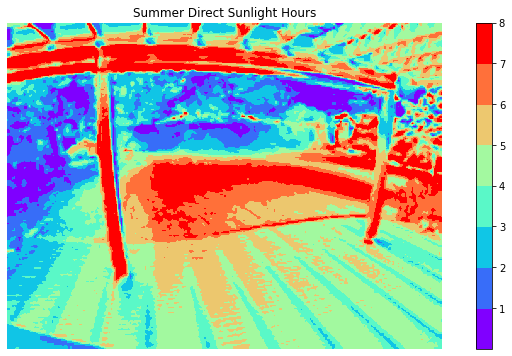

In [13]:
#Total for day = Final item in list of cumulative arrays
final_sunhours = cum_img_array[len(cum_img_array)-1]

#create color mapping
manual_cmap = plt.cm.rainbow
manual_norm = colors.BoundaryNorm(np.arange(0, 9, 1), manual_cmap.N)

#plot
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(final_sunhours, cmap=manual_cmap, norm=manual_norm)
plt.colorbar(ticks=np.linspace(1,8,8))
plt.title("Summer Direct Sunlight Hours")



We see that the north (right) side of the yard gets significantly more sunlight, and is where any "full-sun" plants would do well. Potted plants will still get a decent amount of sun on the patio, but maybe not enough for a "full-sun" plant.  The south (left) and west (rear) sides get very little sun, and will only grow plants that do well in shade.